#### Imports

In [2]:
import numpy
import pandas as panda
import matplotlib.pyplot as plot
import calendar 
from datetime import datetime
from collections import defaultdict
from matplotlib.ticker import FuncFormatter


#### Days in the current month

In [3]:
# Get the current year and month and time
current_date = datetime.now()
current_year = current_date.year
current_month = current_date.month

# Extract the current month's name
current_month_name = current_date.strftime("%B")

# Get the number of days in the current month
_, daysInCurrentMonth = calendar.monthrange(current_year, current_month)

print(f"The current month is {current_month_name} and it has {daysInCurrentMonth} days.")


The current month is July and it has 31 days.


#### Data handling

In [8]:
# read the ods file
ods_data = panda.read_excel('~/Downloads/data.ods', sheet_name='main', engine='odf')

# extract the data from the columns in the ods file
expenses = ods_data['Betrag'].dropna().abs()
dates = ods_data['date'].dropna()

# conver them into a list
expenses = expenses.values.tolist()
dates = dates.values.tolist()

'''
# create a boolean mask whether a value is nan
boolean_mask = ~numpy.isnan(expenses)

# remove any value that is nan
expenses = [ exp for exp, valid in zip(expenses, boolean_mask) if valid ]
dates = [ date for date, valid in zip(dates, boolean_mask) if valid ]
'''

# day-month-year instead of day.month.year
dates = [ str(date.replace('.', '-')) for date in dates ]

'''
# make all values positive in expenses
expenses = [ abs(value) for value in expenses ]
'''

# create a dictionary with the pair (key, value) over tuple(key : value)
date_expense_dict = { (date, expense) for date, expense in zip(dates, expenses) }

# takes a list and returns one which is sorted, rounded and without any redundancy
def aggregate_expenses(dates_expenses):
    # Initialize a default dictionary to store the aggregated expenses
    expenses_dict = defaultdict(float)
    
    # Iterate through the list of date-expense pairs
    for date, expense in dates_expenses:
        # Aggregate the expenses for each date
        expenses_dict[date] += expense
    
    # round the expenses
    rounded_expenses = { 
        date : round(expense, 4) for date, expense in expenses_dict.items() 
    }
    
    # 'key' is executed before any sorting; takes x which is a tuple(key, value), gets the date with x[0] and converts it into a datetime object
    sorted_expenses = dict(sorted(rounded_expenses.items(), key=lambda x: datetime.strptime(x[0], "%d-%m-%y")))
    
    return sorted_expenses

date_expense_dict = aggregate_expenses(date_expense_dict)

print(date_expense_dict)


{'20-06-24': 1.9, '21-06-24': 2.93, '24-06-24': 4.98, '25-06-24': 0.99, '26-06-24': 0.99, '27-06-24': 9.72, '28-06-24': 3.51, '01-07-24': 0.99, '02-07-24': 3.59, '03-07-24': 4.58, '04-07-24': 7.61, '05-07-24': 12.14, '08-07-24': 5.29, '12-07-24': 6.62, '15-07-24': 5.78, '18-07-24': 1.94}


#### Dataframe

In [9]:
# creates the dataframe with the give columns
dataframe = panda.DataFrame(list(date_expense_dict.items()), columns=['date', 'expenses'])

dataframe

,date,expenses
0,20-06-24,1.90
1,21-06-24,2.93
2,24-06-24,4.98
3,25-06-24,0.99
4,26-06-24,0.99
5,27-06-24,9.72
6,28-06-24,3.51
7,01-07-24,0.99
8,02-07-24,3.59
9,03-07-24,4.58


In [10]:
# calculates the average
average = numpy.mean(dataframe['expenses'])

#### Graph
Displays the graph with the given data and the current month

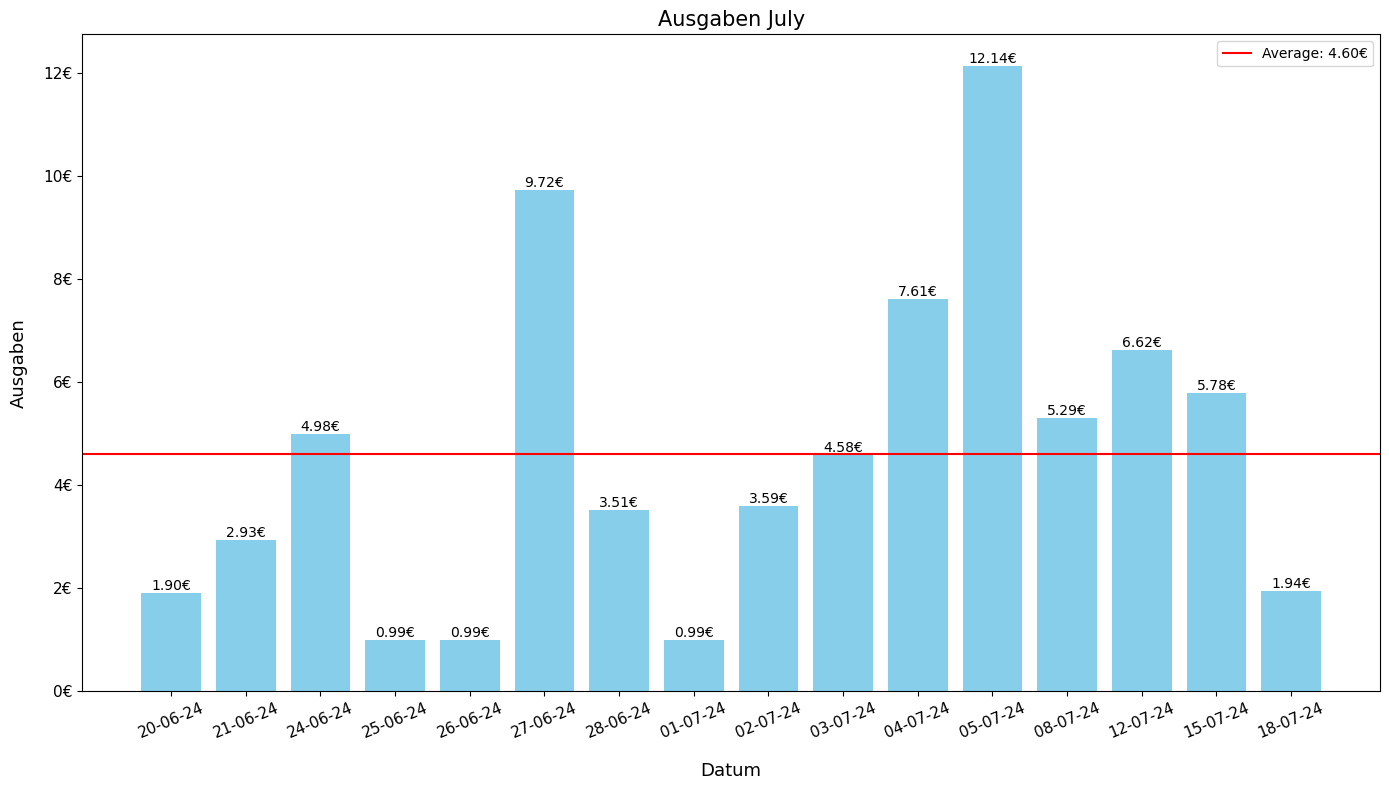

In [11]:
# Changes the size of the bars inside the plot
plot.figure(figsize=(14, 8))

# data of the x-axis/bar value is assigned as they need to be identical
xdata = dataframe['expenses']

# stores the bars inside the variable: how many, the actual values
bars = plot.bar(range(len(dataframe['expenses'])), xdata)

# creates the bars inside the diagram
plot.bar(dataframe['date'], xdata, color='skyblue')

# x: value of tick on an axis; pos: where the tick is located
def currency_formatter(x, pos):
    return f'{x:.0f}€'

# get current axes (gca)
plot.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))

for bar in bars:
    y_axis_value = bar.get_height() # get the y-axis height which corresponds with the y value
    # adds text annotation to the bar; left edge + center = center, y, value 
    plot.text(bar.get_x() + bar.get_width()/2, y_axis_value, f'{y_axis_value:.2f}€', ha='center', va='bottom')

# change the x and y-bar label font size
plot.tick_params(axis='both', labelsize=11)

# axis Labels, font size and distance to the x bar labels
plot.xlabel('Datum', fontsize=13, labelpad=15)
plot.ylabel('Ausgaben', fontsize=13, labelpad=11)

# Title
plot.title(f'Ausgaben {current_month_name}', fontsize=15)

# Rotate the x bar labels by 22.5 degree
plot.xticks(rotation=22.5)

#y: where to line will be drawn
plot.axhline(y=average, color='red', linestyle='-', label=f'Average: {average:.2f}€')

# 
plot.tight_layout()

# displays a legend
plot.legend()

# Shows the plot
plot.show()


In [87]:
print('Summe aller monatlichen Ausgaben: ' + str(dataframe['expenses'].sum()))

Summe aller monatlichen Ausgaben: 73.56


#### Get all the days in a month exercise

In [88]:
# Initializations
i: int = 1
dates = []

# Create an array for the days of the month
while i <= daysInCurrentMonth:
    dates.append(f'{i}-{current_date.strftime("%m-%Y")}')
    i += 1
    

#### User Input Exercise

In [89]:
'''
import sys

from IPython.core.display_functions import clear_output

userinput: str = ''
spendingdata: list[float] = []


#
def getspendings() -> str:
    global spendingdata
    global userinput

    # Get the user input
    userinput = input('Gebe deine Ausgaben ein: ')

    if userinput == 'end':
        return userinput
    else:
        # try to int conversion
        try:
            userinput = float(userinput)
        except ValueError:
            clear_output(wait=True)
            print('Please make sure the input is a number!')
            sys.exit(1)

    # validate the input
    if type(userinput) is float:
        
        if daysInCurrentMonth <= len(spendingdata):
            print('Done!')
            return 'end'
        
        spendingdata.append(userinput)
        print(f'Appended {userinput}')

        return userinput
    else:
        clear_output(wait=True)
        print('Something went wrong!')
        sys.exit(1)


while userinput != 'end':
    userinput = getspendings()
'''

"\nimport sys\n\nfrom IPython.core.display_functions import clear_output\n\nuserinput: str = ''\nspendingdata: list[float] = []\n\n\n#\ndef getspendings() -> str:\n    global spendingdata\n    global userinput\n\n    # Get the user input\n    userinput = input('Gebe deine Ausgaben ein: ')\n\n    if userinput == 'end':\n        return userinput\n    else:\n        # try to int conversion\n        try:\n            userinput = float(userinput)\n        except ValueError:\n            clear_output(wait=True)\n            print('Please make sure the input is a number!')\n            sys.exit(1)\n\n    # validate the input\n    if type(userinput) is float:\n        \n        if daysInCurrentMonth <= len(spendingdata):\n            print('Done!')\n            return 'end'\n        \n        spendingdata.append(userinput)\n        print(f'Appended {userinput}')\n\n        return userinput\n    else:\n        clear_output(wait=True)\n        print('Something went wrong!')\n        sys.exit(1)\